# Federated vs. Centralized Learning for WiFi Sensing using CNN and ResNet-18
## By: Mustafa Yildirim

This project explores the application of Federated Learning (FL) in WiFi Sensing to enhance data privacy while maintaining model performance. Instead of centralizing data, FL allows clients to collaboratively train models while keeping data localized. In this work, we compare ResNet-18 and a traditional CNN model on the UT-HAR dataset, evaluating their performance in both centralized and federated learning settings to assess the impact of distributed training on model accuracy and efficiency.

**Importing Libraries**

In [ ]:
import numpy as np
import glob
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torchvision.models import resnet18

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cuda


**Data Processing**

In [3]:
def UT_HAR_dataset(root_dir):
    data_list = glob.glob(root_dir + '/data/*.csv')
    label_list = glob.glob(root_dir + '/label/*.csv')
    WiFi_data = {}

    expected_keys = ['X_train', 'X_val', 'X_test', 'y_train', 'y_val', 'y_test']

    # Load data
    for data_dir in data_list:
        data_name = data_dir.split('\\')[-1].split('.')[0]
        
        if data_name not in expected_keys:
            continue
        
        with open(data_dir, 'rb') as f:
            data = np.load(f, allow_pickle=True)
            data = data.reshape(len(data), 1, 250, 90)
            data_norm = (data - np.min(data)) / (np.max(data) - np.min(data))
            
        WiFi_data[data_name] = torch.Tensor(data_norm)

    # Load labels
    for label_dir in label_list:
        label_name = label_dir.split('\\')[-1].split('.')[0]
        
        if label_name not in expected_keys:
            continue
        
        with open(label_dir, 'rb') as f:
            label = np.load(f, allow_pickle=True)
        WiFi_data[label_name] = torch.Tensor(label).to(torch.int64)

    return WiFi_data

In [4]:
def preprocess_UT_HAR_data(root_dir):
    
    data = UT_HAR_dataset(root_dir)
    
    X_train = data['X_train']
    y_train = data['y_train']
    
    X_test = data['X_test']
    y_test = data['y_test']
        
    return X_train, y_train, X_test, y_test

In [5]:
root_dir = 'UT_HAR'

X_train, y_train, X_test, y_test = preprocess_UT_HAR_data(root_dir)

In [6]:
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}") 
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")
print(y_train.count_nonzero(), y_test.count_nonzero())

X_train shape: torch.Size([3977, 1, 250, 90])
y_train shape: torch.Size([3977])
X_test shape: torch.Size([500, 1, 250, 90])
y_test shape: torch.Size([500])
tensor(3452) tensor(434)


In [7]:
print(f"Unique labels in y_train: {y_train.unique().tolist()}")
print(f"Number of classes: {y_train.unique().numel()}")
print(f"Unique labels in y_test: {y_test.unique().tolist()}")
print(f"Number of classes: {y_test.unique().numel()}")

Unique labels in y_train: [0, 1, 2, 3, 4, 5, 6]
Number of classes: 7
Unique labels in y_test: [0, 1, 2, 3, 4, 5, 6]
Number of classes: 7


In [8]:
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

**Model Initialization**

CNN

In [9]:
class CNNModel(nn.Module):
    def __init__(self, num_classes):
        super(CNNModel, self).__init__()
        
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.fc1 = nn.Linear(64 * 31 * 11, 128)
        self.fc2 = nn.Linear(128, num_classes)
        self.relu = nn.ReLU()
        
    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.pool(x)
        x = self.relu(self.conv2(x))
        x = self.pool(x)
        x = self.relu(self.conv3(x))
        x = self.pool(x)
        x = x.view(x.size(0), -1)
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x

ResNet-18

In [10]:
class ResNet18(nn.Module):
    def __init__(self, num_classes):
        super(ResNet18, self).__init__()

        self.model = resnet18(weights=None)
        self.model.conv1 = nn.Conv2d(in_channels=1, out_channels= 64, kernel_size=7, stride= 2, padding= 3, bias=False)
        self.model.fc = nn.Linear(self.model.fc.in_features, num_classes)
        
    def forward(self, x):
        return self.model(x)

**Federated learning training function**

In [11]:
def federated_train(client_dataloaders, global_model, num_rounds=5, local_epochs=1, model_type="cnn"):
    
    global_model.to(device)
    round_accuracies = []
    
    for round in range(num_rounds):
        print(f'Round {round + 1}/{num_rounds}')
        
        client_models = []
        total_train_correct = 0
        total_train_samples = 0 

        for client_loader in client_dataloaders:
            
            if model_type.lower() == "cnn":
                client_model = CNNModel(num_classes=len(torch.unique(y_train)))
            elif model_type.lower() == "resnet":    
                client_model = ResNet18(num_classes=len(torch.unique(y_train)))
            else:
                raise ValueError("Invalid model_type. Choose 'cnn' or 'resnet'.")
            
            client_model.load_state_dict(global_model.state_dict())
           
            client_model.to(device) 
            client_optimizer = optim.Adam(client_model.parameters(), lr=0.001)
            client_loss_fn = nn.CrossEntropyLoss()
            
            client_model.train()

            # Train on client data for multiple local epochs
            for epoch in range(local_epochs):
                for inputs, labels in client_loader:
                    inputs, labels = inputs.to(device), labels.to(device)
                    client_optimizer.zero_grad()
                    outputs = client_model(inputs)
                    loss = client_loss_fn(outputs, labels)
                    loss.backward()
                    client_optimizer.step()

                    # Calculate training accuracy
                    _, predicted = torch.max(outputs.data, 1)
                    total_train_correct += (predicted == labels).sum().item()
                    total_train_samples += labels.size(0)

            client_models.append(client_model)

        # Calculate and store training accuracy for this round
        train_accuracy = 100 * total_train_correct / total_train_samples
        round_accuracies.append(train_accuracy)
        print(f'Training Accuracy: {train_accuracy:.2f}%')

        # Aggregate client models
        global_state_dict = global_model.state_dict()
        for key in global_state_dict:
            global_state_dict[key] = torch.stack([model.state_dict()[key].float() for model in client_models], 0).mean(0)
        global_model.load_state_dict(global_state_dict)
        print('Model aggregated')
    
    return round_accuracies

**Function for evaluating the model**

In [12]:
def evaluate_model(model, testloader):
    model.to(device)
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            images, labels = images.to(device), labels.to(device) 
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    print(f'Test Accuracy: {100 * correct / total:.2f}%')

**Function for plotting the training accuracy vs. rounds**

In [13]:
def plot_training_accuracy_vs_rounds(num_users_list, round_accuracies_list, num_rounds, model_type=" "):
    for num_users, accuracies in zip(num_users_list, round_accuracies_list):
        plt.plot(range(1, num_rounds + 1), accuracies, marker='o', label=f'{num_users} Users')
    plt.xlabel('Number of Rounds')
    plt.ylabel('Training Accuracy (%)')
    plt.title(f'{model_type}: Training Accuracy vs. Number of Rounds')
    plt.legend()
    plt.grid(True)
    plt.show()

**Training and Testing**

In [14]:
num_rounds = 10
local_epochs = 3
num_users_list = [1, 5, 10]

round_accuracies_cnn_list = []
round_accuracies_resnet_list = []

for num_users in num_users_list:

    client_dataloaders = [DataLoader(train_dataset, batch_size=64, shuffle=True) for _ in range(num_users)]
    
    print(f"\nTraining Federated Model with {num_users} clients (CNN)...")
    cnn_net = CNNModel(num_classes=len(torch.unique(y_train))).to(device)
    round_accuracies_cnn = federated_train(client_dataloaders, cnn_net, num_rounds=num_rounds, local_epochs=local_epochs, model_type="cnn")
    round_accuracies_cnn_list.append(round_accuracies_cnn)

    print(f"\nTraining Federated Model with {num_users} clients (ResNet)...")
    resnet_net = ResNet18(num_classes=len(torch.unique(y_train))).to(device)
    round_accuracies_resnet = federated_train(client_dataloaders, resnet_net, num_rounds=num_rounds, local_epochs=local_epochs, model_type="resnet")
    round_accuracies_resnet_list.append(round_accuracies_resnet)

    # Evaluate both models
    print(f'\nTest Accuracy for {num_users} clients (CNN):')
    evaluate_model(cnn_net, test_loader)
    
    print(f'\nTest Accuracy for {num_users} clients (ResNet):')
    evaluate_model(resnet_net, test_loader)


Training Federated Model with 1 clients (CNN)...
Round 1/10
Training Accuracy: 46.89%
Model aggregated
Round 2/10
Training Accuracy: 76.77%
Model aggregated
Round 3/10
Training Accuracy: 88.06%
Model aggregated
Round 4/10
Training Accuracy: 93.07%
Model aggregated
Round 5/10
Training Accuracy: 96.24%
Model aggregated
Round 6/10
Training Accuracy: 97.63%
Model aggregated
Round 7/10
Training Accuracy: 97.98%
Model aggregated
Round 8/10
Training Accuracy: 98.59%
Model aggregated
Round 9/10
Training Accuracy: 98.52%
Model aggregated
Round 10/10
Training Accuracy: 99.38%
Model aggregated

Training Federated Model with 1 clients (ResNet)...
Round 1/10
Training Accuracy: 84.39%
Model aggregated
Round 2/10
Training Accuracy: 94.33%
Model aggregated
Round 3/10
Training Accuracy: 96.04%
Model aggregated
Round 4/10
Training Accuracy: 97.25%
Model aggregated
Round 5/10
Training Accuracy: 98.19%
Model aggregated
Round 6/10
Training Accuracy: 98.27%
Model aggregated
Round 7/10
Training Accuracy: 98

**Visualizations**

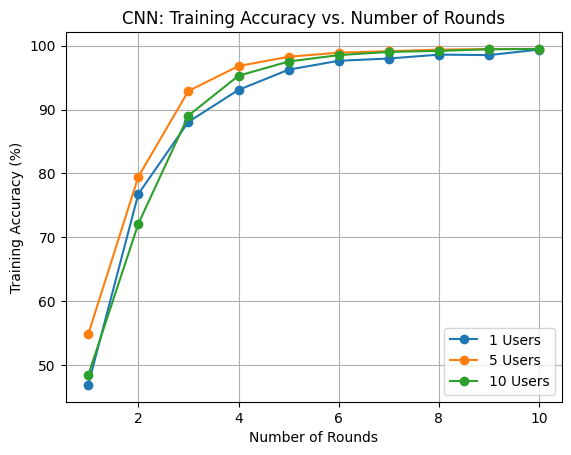

In [15]:
plot_training_accuracy_vs_rounds(num_users_list, round_accuracies_cnn_list, num_rounds,"CNN")

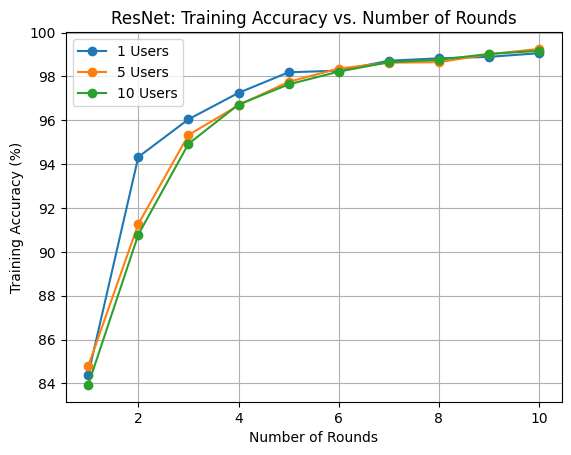

In [16]:
plot_training_accuracy_vs_rounds(num_users_list, round_accuracies_resnet_list, num_rounds, "ResNet")

**Results and Analysis:**

This experiment evaluates the performance of CNN and ResNet-18 in both centralized learning (1 client) and federated learning (FL) settings (5 and 10 clients) using the UT-HAR dataset. The models were trained over 10 global rounds with 3 local epochs per client, and their accuracy was tracked across different client distributions.


**Training Performance:**
The 1-client setting represents centralized learning, where the model is trained on the entire dataset without distribution across multiple clients.
ResNet-18 showed a faster training accuracy increase compared to CNN in FL, achieving over 93% by round 5, while CNN improved more gradually.
CNN and ResNet-18 both reached nearly 99% training accuracy when trained across multiple clients in FL.
More clients in FL led to better accuracy for both models due to improved data distribution.


**Test Accuracy Comparison:**
In centralized learning (1 client), CNN significantly outperformed ResNet-18 on test accuracy (95.00% vs. 59.60%), indicating that ResNet-18 might have overfitted due to limited training data.
With 5 clients, both models performed well, with CNN achieving 96.80% and ResNet-18 reaching 95.60%, suggesting that CNN generalized slightly better in this case.
With 10 clients, ResNet-18 outperformed CNN (98.60% vs. 97.40%), demonstrating that ResNet-18 benefits more from federated learning with increased data diversity.
As the number of clients increased, test accuracy generally improved, confirming the advantage of federated training.


**Key Observations:**
Centralized learning (1 client) can achieve high accuracy but may lead to overfitting, particularly for deeper models like ResNet-18.
Federated learning benefits from more clients, as seen in both CNN and ResNet-18, with test accuracy improving as the number of clients increases.
ResNet-18 exhibited higher performance gains in FL when more clients participated, whereas CNN was more stable across different settings.
The choice between CNN and ResNet-18 depends on the available training setup, with CNN performing better in centralized settings and ResNet-18 benefiting from FL with more clients.